In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from verstack import NaNImputer

from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import svm
from lightgbm import LGBMRegressor

import joblib

pd.set_option('future.no_silent_downcasting', True)

load_dotenv()

user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
db = os.getenv("DB_NAME")
TABLE_NAME = os.getenv("TABLE_NAME")



In [3]:
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{db}")

## Collecting Basic Info

In [88]:
dataset_train = pd.read_csv(r"C:\Users\healk\Desktop\PROJECT_LEAVERS\train_podcast.csv")

In [6]:
dataset_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [7]:
for col in dataset_train.columns:
    pct_missing = np.mean(dataset_train[col].isnull())
    print(col, f'{pct_missing * 100}%')

print(len(dataset_train))

id 0.0%
Podcast_Name 0.0%
Episode_Title 0.0%
Episode_Length_minutes 11.612400000000001%
Genre 0.0%
Host_Popularity_percentage 0.0%
Publication_Day 0.0%
Publication_Time 0.0%
Guest_Popularity_percentage 19.470666666666666%
Number_of_Ads 0.00013333333333333334%
Episode_Sentiment 0.0%
Listening_Time_minutes 0.0%
750000


In [8]:
dataset_train.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

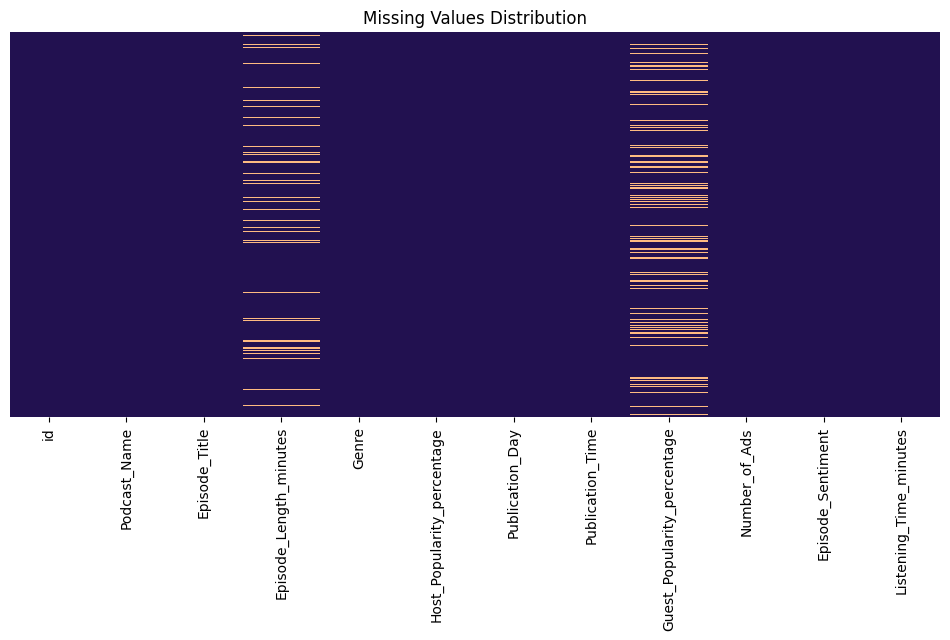

In [9]:
plt.figure(figsize=(12, 5))
plt.title("Missing Values Distribution")
sns.heatmap(dataset_train.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

In [10]:

for col in dataset_train.select_dtypes(exclude=['number']).columns:
    unique_count = dataset_train[col].nunique()
    print(f"Column '{col}' has {unique_count} unique value(s).")

Column 'Podcast_Name' has 48 unique value(s).
Column 'Episode_Title' has 100 unique value(s).
Column 'Genre' has 10 unique value(s).
Column 'Publication_Day' has 7 unique value(s).
Column 'Publication_Time' has 4 unique value(s).
Column 'Episode_Sentiment' has 3 unique value(s).


In [11]:
query = f'select * from {TABLE_NAME} where \"Podcast_Name\" LIKE \'Business Insights\' and \"Episode_Title\" LIKE \'Episode 11\''
df = pd.read_sql(query, engine)
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,3486,Business Insights,Episode 11,7.31,Business,31.24,Saturday,Morning,26.53,1.0,Positive,0.00000
1,11137,Business Insights,Episode 11,102.71,Business,70.94,Monday,Night,70.99,0.0,Neutral,93.04420
2,16199,Business Insights,Episode 11,84.03,Business,84.05,Saturday,Evening,1.93,2.0,Neutral,48.67714
3,23757,Business Insights,Episode 11,36.90,Business,28.72,Monday,Afternoon,73.70,1.0,Neutral,12.96017
4,25942,Business Insights,Episode 11,42.11,Business,79.11,Sunday,Night,73.62,1.0,Negative,11.59559


This query show that there is no sense in episode title, so it makes sense to drop this column later while preparing model to training

# Univarible EDA

In [14]:
dataset_train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


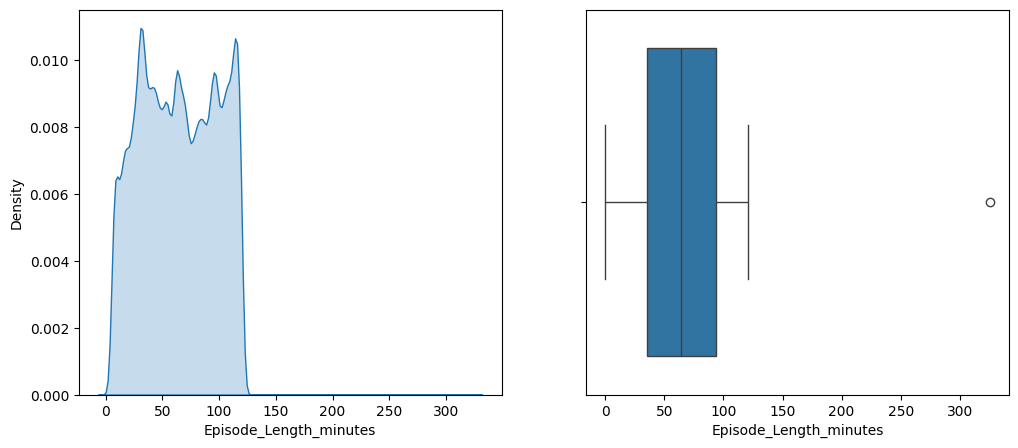

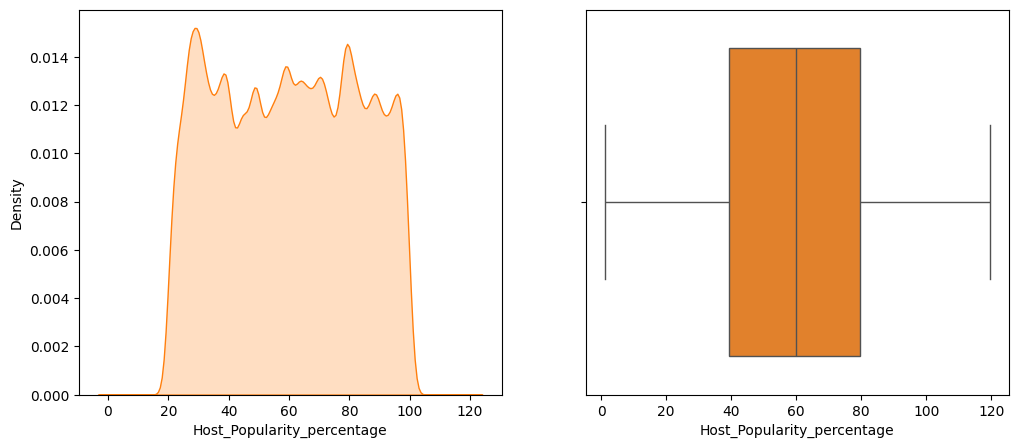

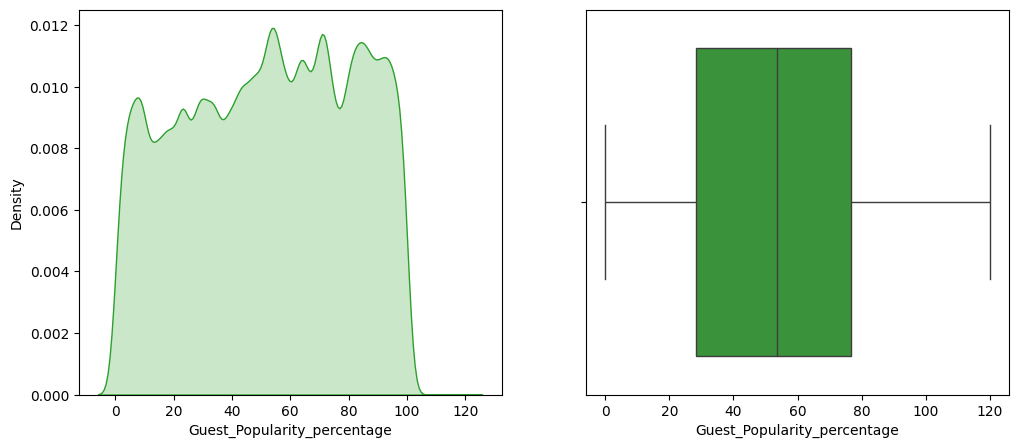

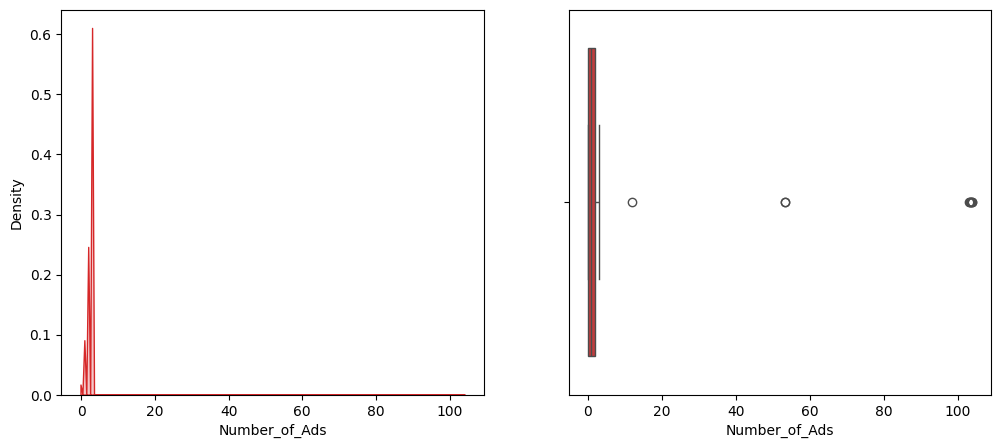

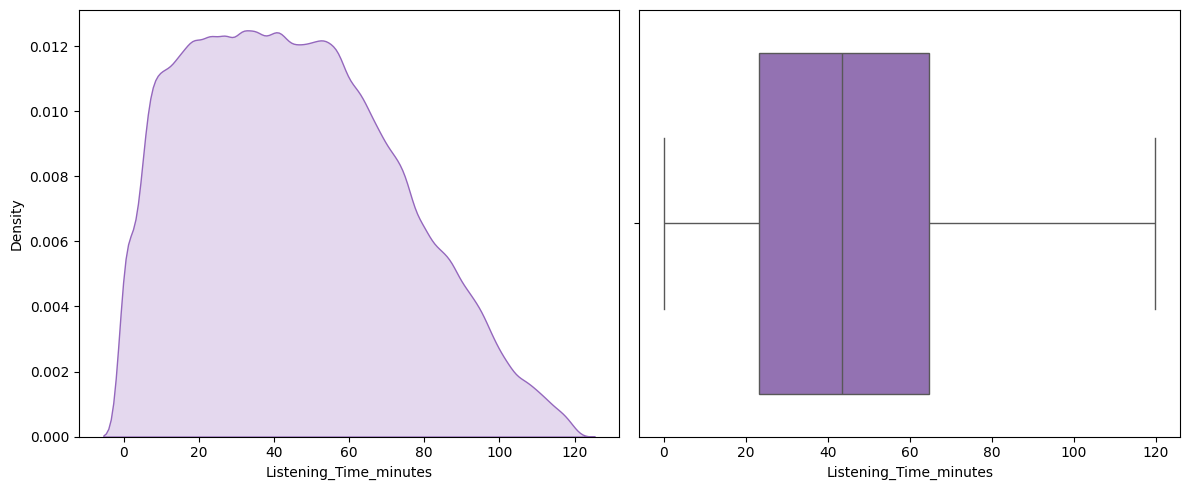

<Figure size 640x480 with 0 Axes>

In [15]:
dataset_numerical = dataset_train.select_dtypes(include=['number'])
dataset_categorical = dataset_train.select_dtypes(include=['object'])
dataset_numerical = dataset_numerical.drop(['id'], axis=1)
dataset_categorical = dataset_categorical.drop(['Episode_Title'], axis=1)
numerical_cols = dataset_numerical.columns
categorical_cols = dataset_categorical.columns

palette = sns.color_palette('tab10', len(numerical_cols))
color_dict = dict(zip(numerical_cols, palette))

for col in numerical_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.kdeplot(data=dataset_numerical, x=col, color=color_dict[col], fill=True, ax = ax[0])
    
    sns.boxplot(data=dataset_numerical, x=col, color=color_dict[col], ax=ax[1])
    
plt.tight_layout()
plt.show()
plt.savefig('plot.png')    
    


The result that are seen from plots:

**Episode_Length_minutes**: has clear outliners, and looking at listening_time_minutes we can provide hypotethis that some of this outliners are just misleading and its better to remove, requires checking episodes which are longer then 2 hours.

**Host_Popularity_percentage** and **Guest_Popularity_percentage**: despite missing data on the second column, they have a well balanced median on the boxplot and no significant outliners, so after data imputing this data will be quite workable

**Number_of_Ads**: requires removing weird outliners and remaking the plot since 50 and 100 ads in 2h podcasts are clearly misleading

**Listening_Time_minutes**: right-skewed KDE and majority of outliners are on the right side of boxplot as a consequence 


In [17]:
query = f'select * from {TABLE_NAME} where "Number_of_Ads" > 5 or "Episode_Length_minutes" > 121 or "Host_Popularity_percentage" > 100 or "Guest_Popularity_percentage" > 100;'

df = pd.read_sql(query, engine)
print(len(df))

dataset_train = dataset_train.merge(df, how='outer', indicator=True)
dataset_train = dataset_train[dataset_train['_merge'] == 'left_only'].drop(columns=['_merge'])

print(len(dataset_train))


54
749946


so as we see we won't lose much data if we clear obvious outliners, to check new graphics just reload the cell


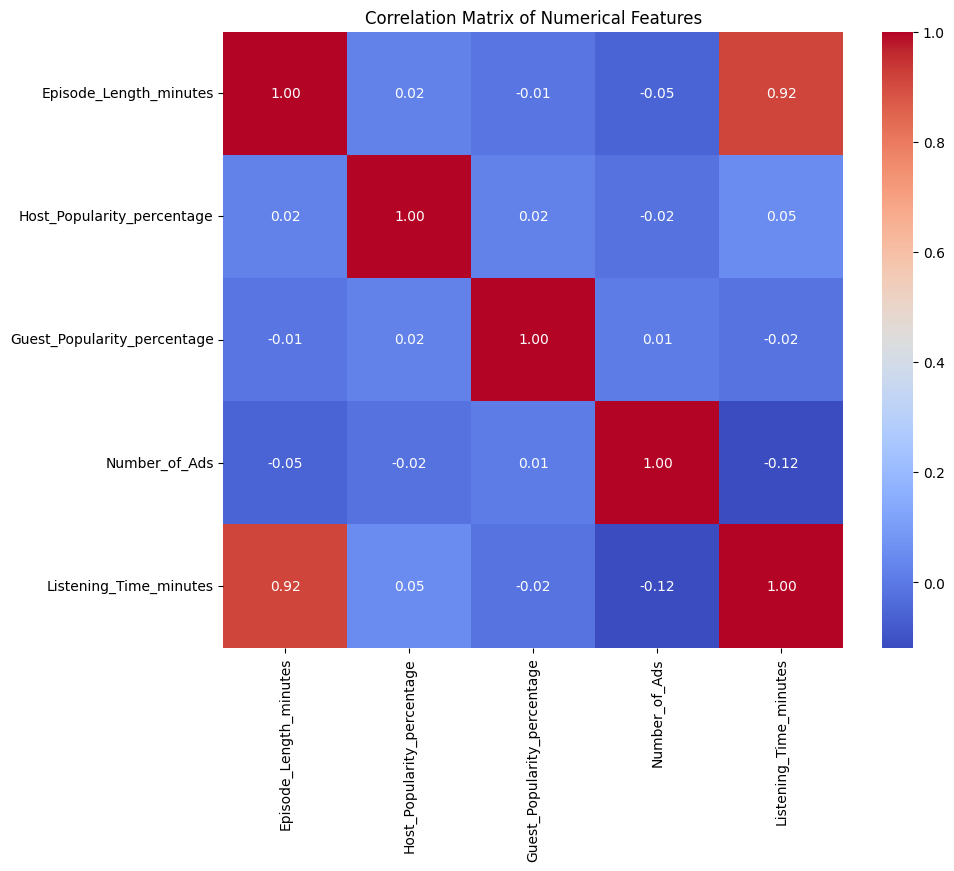

In [19]:
correlation_matrix = dataset_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Text(0, 0.5, 'Count')

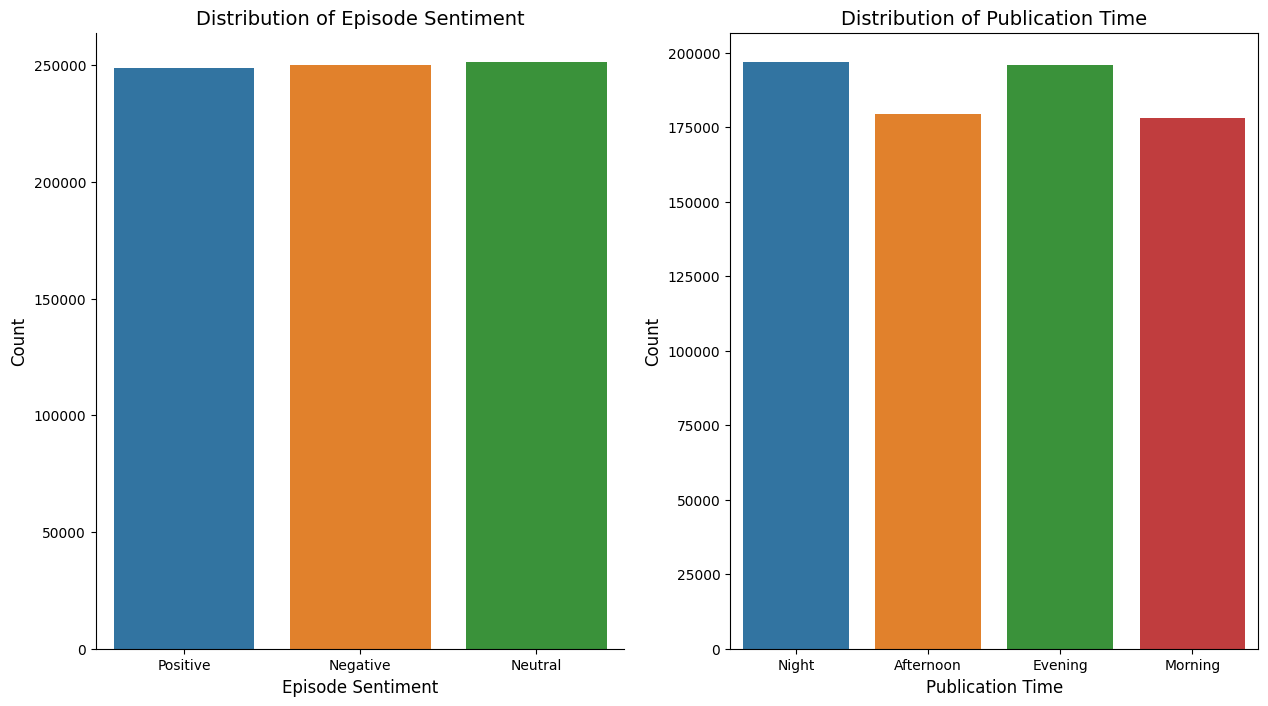

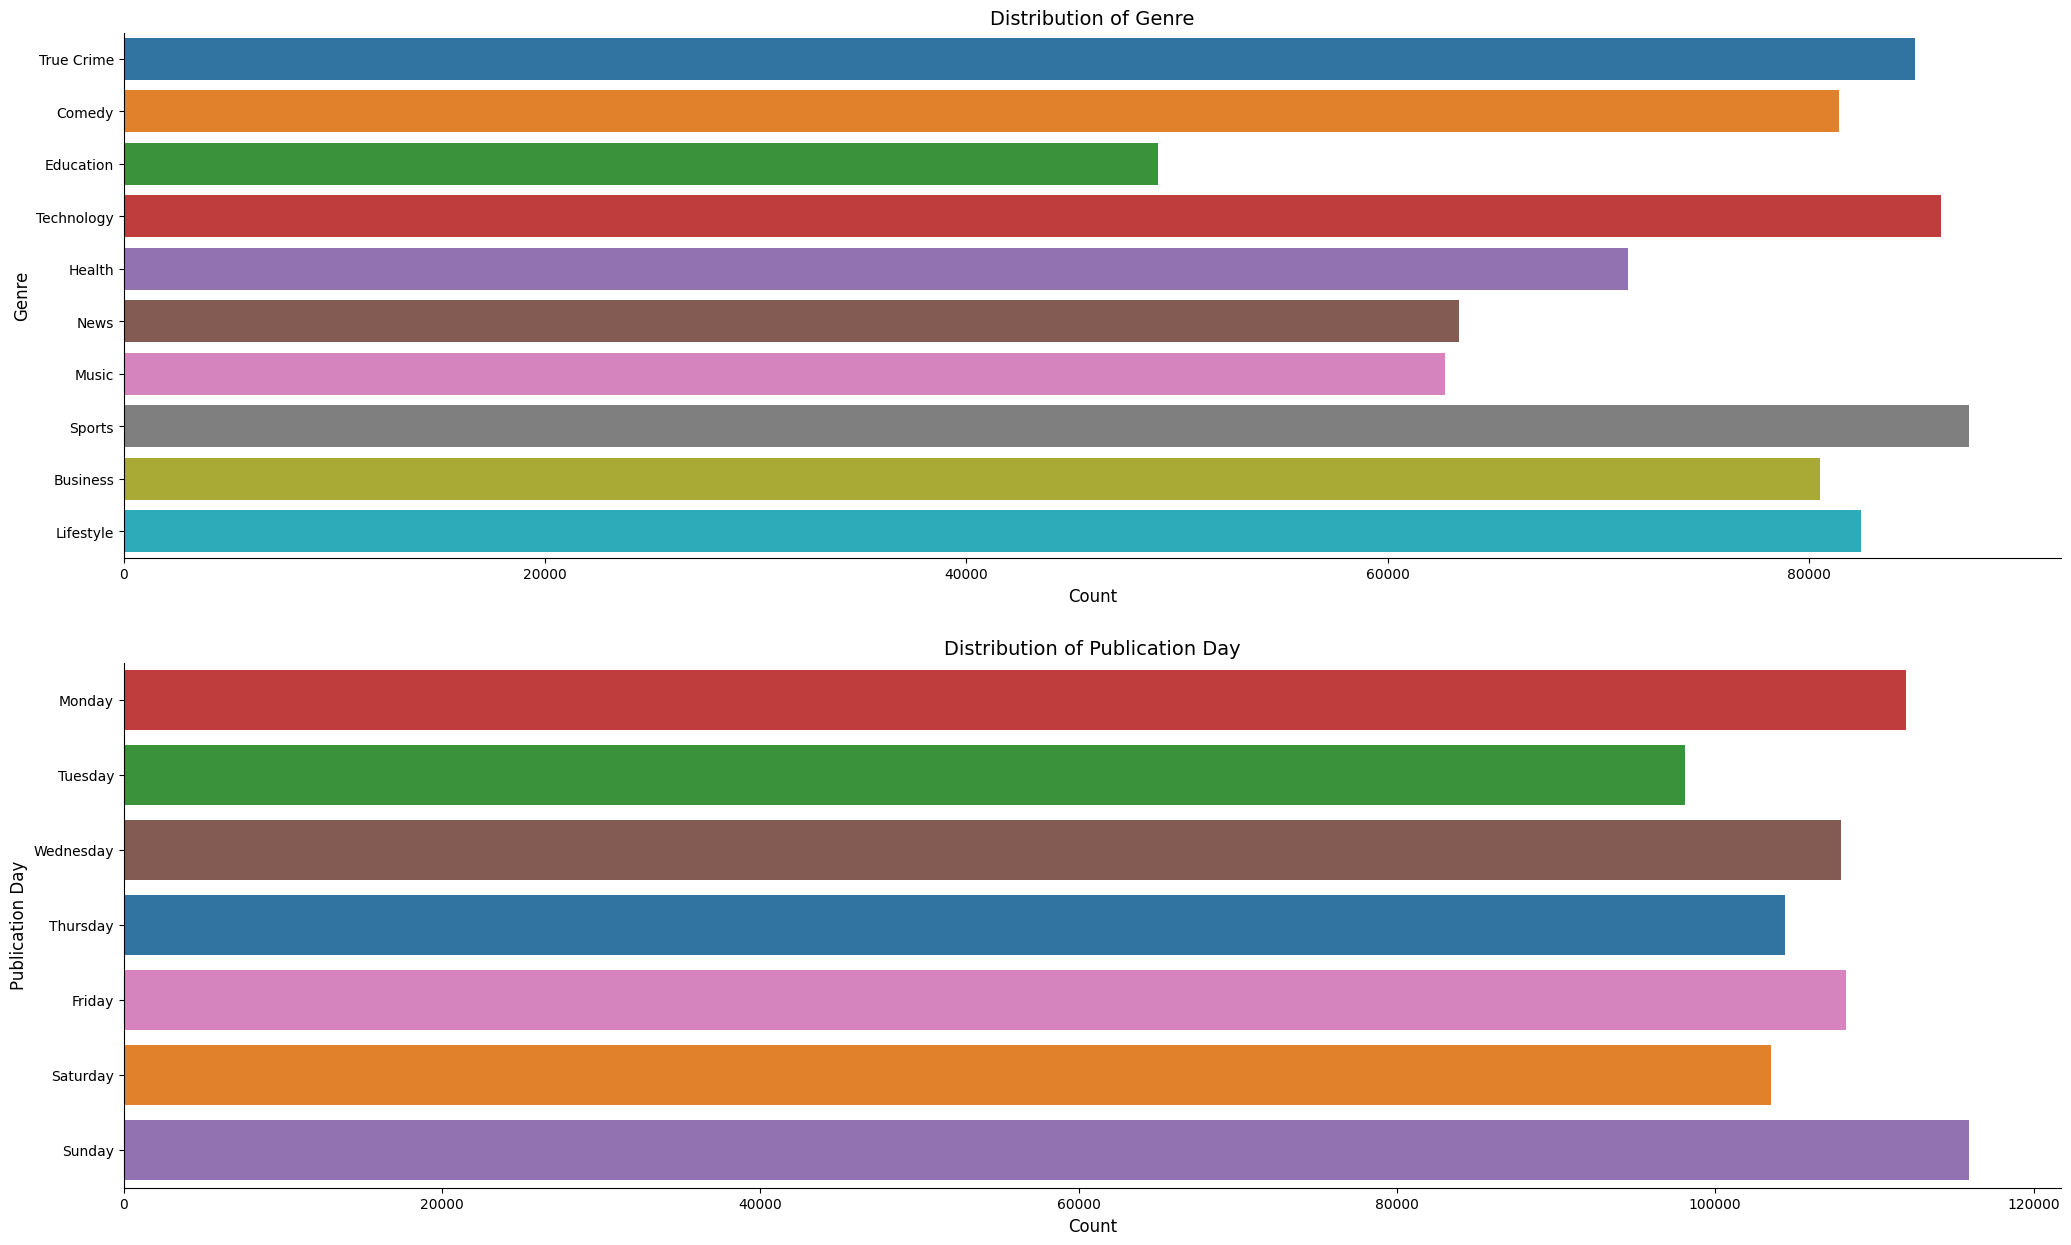

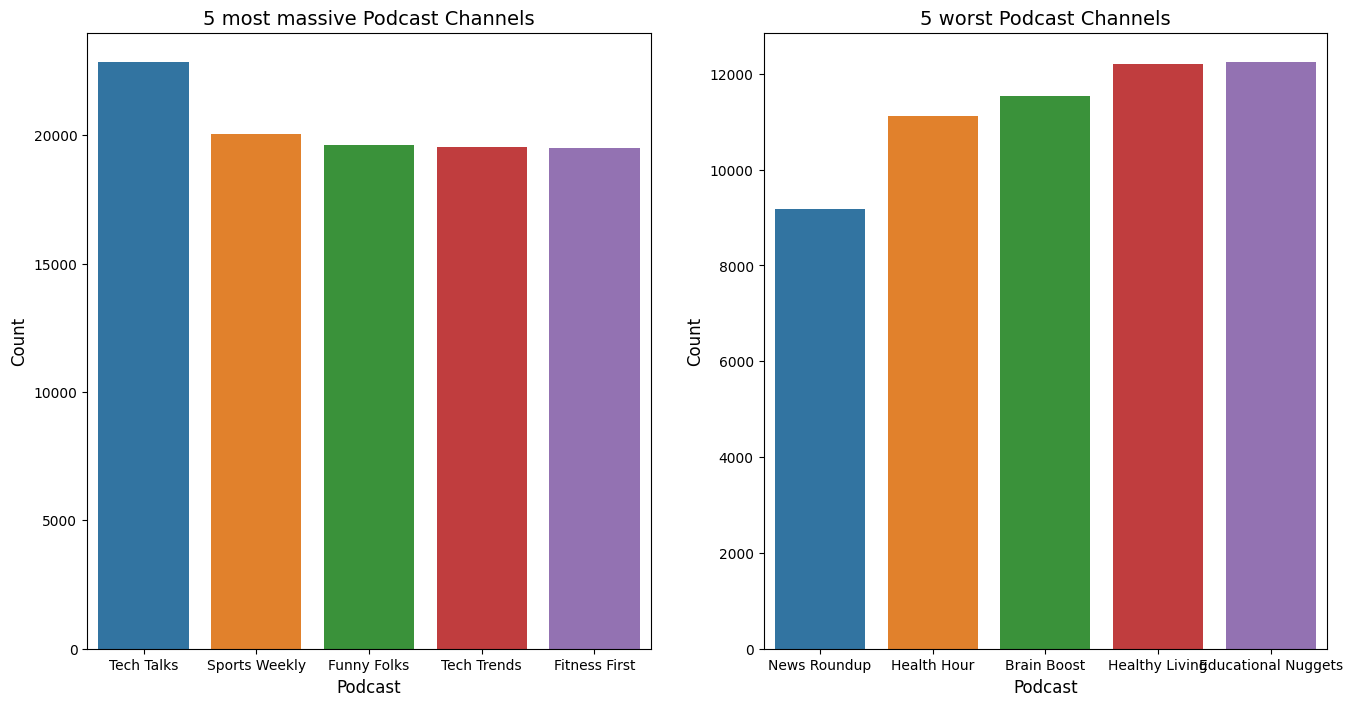

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.countplot(data=dataset_categorical, x='Episode_Sentiment', hue='Episode_Sentiment', ax=axes[0], palette='tab10', legend=False)
axes[0].set_title('Distribution of Episode Sentiment', fontsize=14)
axes[0].set_xlabel('Episode Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
sns.despine(ax=axes[0])

sns.countplot(data=dataset_categorical, x='Publication_Time', hue='Publication_Time', ax=axes[1], palette='tab10', legend=False)
axes[1].set_title('Distribution of Publication Time', fontsize=14)
axes[1].set_xlabel('Publication Time', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
sns.despine(ax=axes[0])

fig, axes = plt.subplots(2, 1, figsize=(25, 15))

sns.countplot(data=dataset_categorical, y='Genre', hue='Genre', ax=axes[0], palette = 'tab10', legend=False)
axes[0].set_title('Distribution of Genre', fontsize=14)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Genre', fontsize=12)
sns.despine(ax=axes[0])


sns.countplot(data=dataset_categorical, y='Publication_Day', hue='Publication_Day', 
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ax=axes[1], palette='tab10', legend=False)
axes[1].set_title('Distribution of Publication Day', fontsize=14)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Publication Day', fontsize=12)
sns.despine(ax=axes[1])

best_stations = dataset_categorical['Podcast_Name'].value_counts().nlargest(5)
worst_stations = dataset_categorical['Podcast_Name'].value_counts().nsmallest(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(x=best_stations.index, y=best_stations.values, hue=best_stations.index, ax=axes[0], palette='tab10', legend=False)
axes[0].set_title('5 most massive Podcast Channels', fontsize=14)
axes[0].set_xlabel('Podcast', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
sns.barplot(x=worst_stations.index, y=worst_stations.values, hue=worst_stations.index, ax=axes[1], palette='tab10', legend=False)
axes[1].set_title('5 worst Podcast Channels', fontsize=14)
axes[1].set_xlabel('Podcast', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
 

categorical data hides no insights here, balanced data on episode sentiment and publication time, close to be balanced data on genre and podcasts channel with the most popular category having about 2x the least popular, so to find some more notes we will move on to data imputing and feature engineering

# data imputing


**NOTE**: There were 3 tries with different imputers such as **NaNImputer**, **IterativeImputer** and **KNNImputer**. So, the third one could not even load even with n_neighbors = 1 and since that requieres GPU Dataframes computations. However, some kaggle reports said that even this won't help, so it was desided to skip this option. IterativeImputer had round 5 seconds execution time but from KDE plot it was seen that the result is way more close to inputing mean/median into NaN values than NaNImputer was. Reader can proof it by loading the same plots for dataset_perfect. Result will be attached in a PNG file in image folder. Its really crucial to stay away from direct mean substitution result because we are having 0.92 correlation between one of our columns and target columns, and the data in this column is spreaded practically equally in KDE plot

In [24]:
dataset_noleakage = dataset_train.drop(['id', 'Listening_Time_minutes', 'Episode_Title'], axis=1)
dataset_noleakage_nums = dataset_noleakage.select_dtypes(include=['number'])
impute_it = NaNImputer(train_sample_size = 300000)
dataset_noleakage_nums = impute_it.impute(dataset_noleakage_nums)
dataset_noleakage_nums = pd.DataFrame(dataset_noleakage_nums, columns=numerical_cols[:-1])

dataset_noleakage_non_nums = dataset_noleakage.drop(columns=dataset_noleakage_nums.columns)

dataset_perfect_noleakage = pd.concat([dataset_noleakage_non_nums, dataset_noleakage_nums], axis=1)
dataset_perfect = pd.concat([dataset_perfect_noleakage, dataset_train[['Listening_Time_minutes']]], axis=1)
dataset_perfect.head()


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         749946
     .. columns:      4
     .. mb in memory: 28.61
     .. NaN cols num: 3

   - Drop hopeless NaN cols

   - Processing whole data for imputation

   - Imputing single core 3 cols
     . Imputed (regression) - 87087    NaN in Episode_Length_minutes
     . Imputed (regression) - 146028   NaN in Guest_Popularity_percentage
     . Imputed (multiclass) - 1        NaN in Number_of_Ads

   - Missing values after imputation: 0

Time elapsed for impute execution: 14.5406 seconds


,Podcast_Name,Genre,Publication_Day,Publication_Time,Episode_Sentiment,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
0,Mystery Matters,True Crime,Thursday,Night,Positive,65.22274,74.81,52.792943,0.0,31.41998
1,Joke Junction,Comedy,Saturday,Afternoon,Negative,119.80000,66.95,75.950000,2.0,88.01241
2,Study Sessions,Education,Tuesday,Evening,Negative,73.90000,69.97,8.970000,0.0,44.92531
3,Digital Digest,Technology,Monday,Morning,Positive,67.17000,57.22,78.700000,2.0,46.27824
4,Mind & Body,Health,Monday,Afternoon,Neutral,110.51000,80.07,58.680000,3.0,75.61031


In [25]:
'''
dataset_noleakage = dataset_train.drop(['id', 'Listening_Time_minutes'], axis=1)
dataset_noleakage.head()
dataset_noleakage_nums = dataset_noleakage.select_dtypes(include=['number'])
impute_it = IterativeImputer()
impute_it.fit(dataset_noleakage_nums)
dataset_noleakage_nums = impute_it.transform(dataset_noleakage_nums)
dataset_noleakage_nums = pd.DataFrame(dataset_noleakage_nums, columns=numerical_cols[:-1])
dataset_noleakage_nums.head()
'''

"\ndataset_noleakage = dataset_train.drop(['id', 'Listening_Time_minutes'], axis=1)\ndataset_noleakage.head()\ndataset_noleakage_nums = dataset_noleakage.select_dtypes(include=['number'])\nimpute_it = IterativeImputer()\nimpute_it.fit(dataset_noleakage_nums)\ndataset_noleakage_nums = impute_it.transform(dataset_noleakage_nums)\ndataset_noleakage_nums = pd.DataFrame(dataset_noleakage_nums, columns=numerical_cols[:-1])\ndataset_noleakage_nums.head()\n"

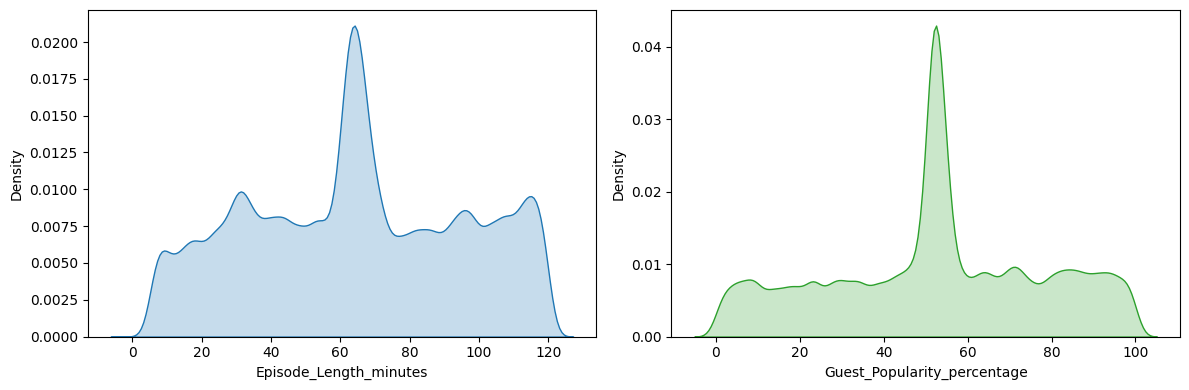

In [26]:
dataset_numerical = dataset_perfect.select_dtypes(include=['number'])
dataset_categorical = dataset_perfect.select_dtypes(include=['object'])
numerical_cols = dataset_numerical.columns
categorical_cols = dataset_categorical.columns

palette = sns.color_palette('tab10', len(numerical_cols))
color_dict = dict(zip(numerical_cols, palette))


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data=dataset_numerical, x='Episode_Length_minutes', color=color_dict['Episode_Length_minutes'], fill=True, ax = ax[0])
sns.kdeplot(data=dataset_numerical, x='Guest_Popularity_percentage', color=color_dict['Guest_Popularity_percentage'], fill=True, ax=ax[1])


plt.tight_layout()
plt.show()

# Feature Engineering and Multivariable Analysis


Text(0.5, 1.0, 'Listening Time vs Episode Time')

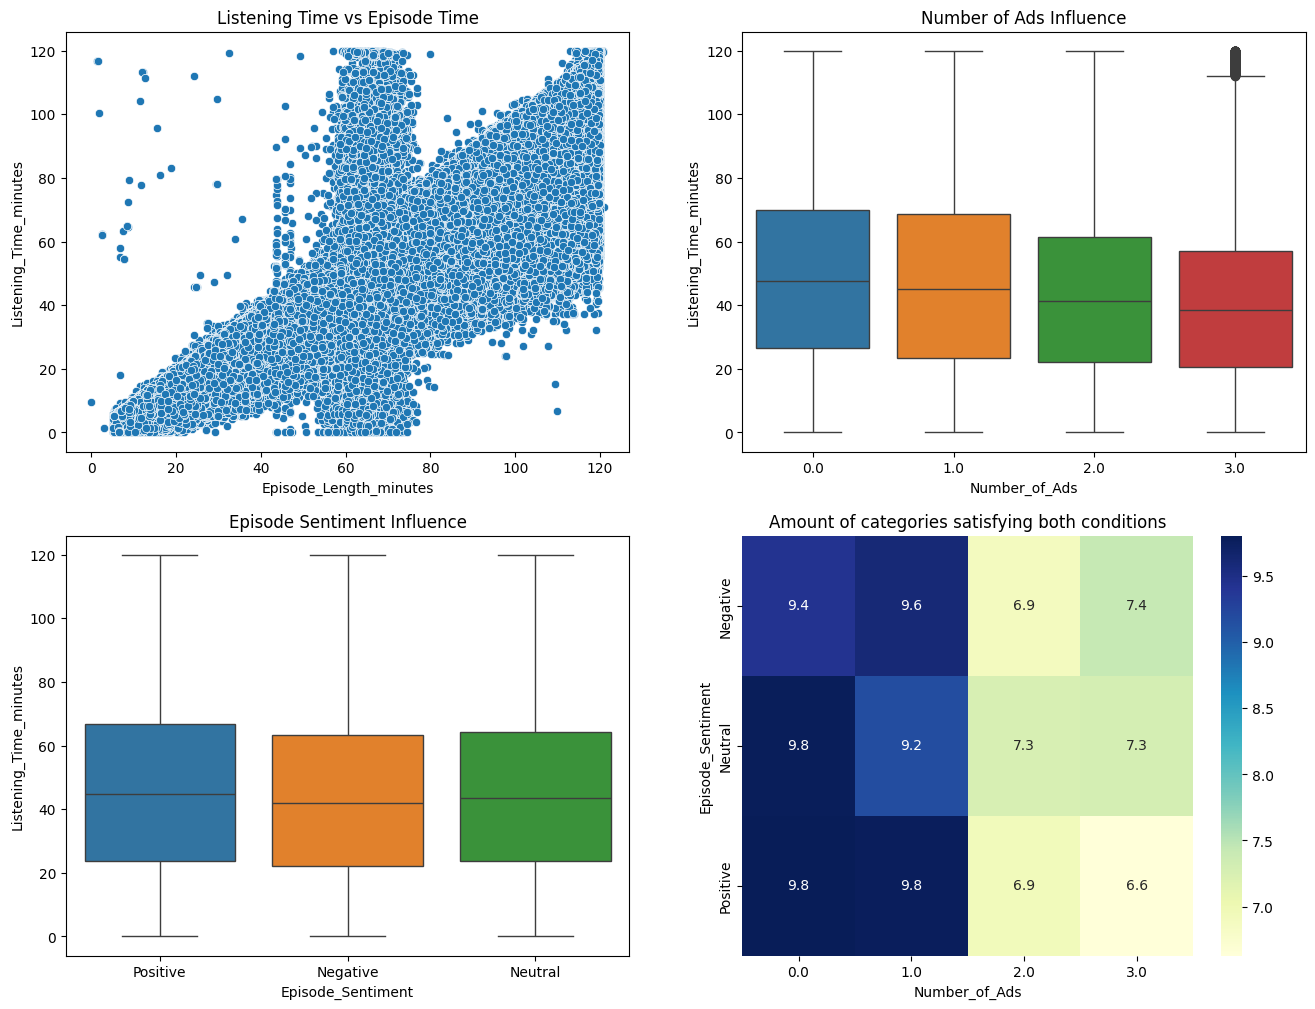

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.scatterplot(data=dataset_numerical, x='Episode_Length_minutes', y='Listening_Time_minutes', ax=ax[0, 0])
sns.boxplot(data=dataset_numerical, x='Number_of_Ads', y='Listening_Time_minutes', palette='tab10', ax=ax[0, 1])
sns.boxplot(data=dataset_perfect, x='Episode_Sentiment', y='Listening_Time_minutes', palette='tab10', ax=ax[1, 0])
sns.heatmap((pd.crosstab(dataset_perfect['Episode_Sentiment'], dataset_perfect['Number_of_Ads'], normalize='all') * 100), annot=True, fmt=".1f", cmap="YlGnBu", ax=ax[1, 1])
ax[1, 1].set_title('Amount of categories satisfying both conditions')
ax[1, 0].set_title('Episode Sentiment Influence')
ax[0, 1].set_title('Number of Ads Influence')
ax[0, 0].set_title('Listening Time vs Episode Time')
#plots of host and guest popularities make no sense in the current form of this columns since low correlation

So, there is clearly an anomaly in the first plot. Obviously, all the rows with listening_time_minutes > episode_length_minutes are clearly false, and the reason we are having this much of that type of columns is data imputing without target column, so we have to choose the least evil of 2 between data leakage and abnormal data distribution. Also, I tasted different train_data_sample in NaNimputer to reduce the amount of abnormal points. The result is following:

750.000: 2.86%

300.000: 2.86%

100.000: 2.86%

50.000: 2.87%

10.000: 2.90%

IterativeImputer: 32.3% (lmao)

It was decided to keep model with 300.000 sample size (tooks 13 seconds to compute on average)

Note that downside there is clear outliners too so we will eliminate them for our training dataset dataset_perfect

2.8647395945841434%
728462
1.5989151218887758%
716471


Text(0.5, 0, 'percentage of listened minutes')

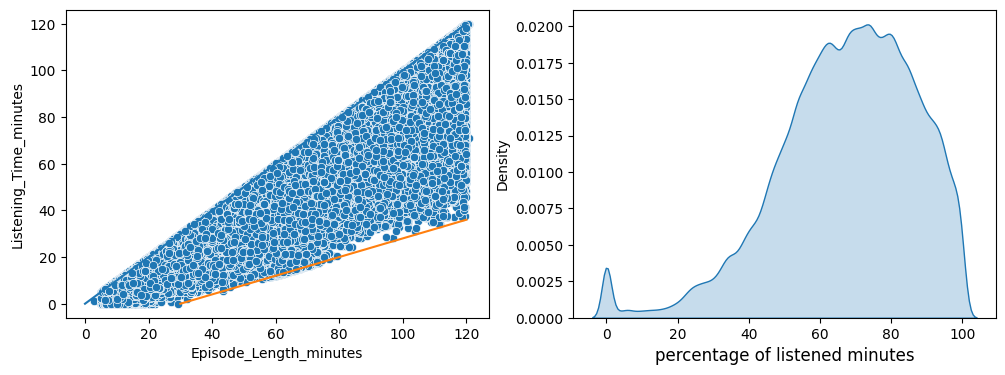

In [30]:
proc = dataset_perfect[dataset_perfect['Listening_Time_minutes'] > dataset_perfect['Episode_Length_minutes']]

print(f'{len(proc)/len(dataset_numerical)*100}%')

dataset_perfect = dataset_perfect.merge(proc, how='outer', indicator=True)
dataset_perfect = dataset_perfect[dataset_perfect['_merge'] == 'left_only'].drop(columns=['_merge'])

print(len(dataset_perfect))

proc = dataset_perfect[dataset_perfect['Listening_Time_minutes'] < (0.4*dataset_perfect['Episode_Length_minutes'] - 12)]
print(f'{len(proc)/len(dataset_numerical)*100}%') #of the unchanged dataset

dataset_perfect = dataset_perfect.merge(proc, how='outer', indicator=True)
dataset_perfect = dataset_perfect[dataset_perfect['_merge'] == 'left_only'].drop(columns=['_merge'])

print(len(dataset_perfect))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt1 = sns.scatterplot(data=dataset_perfect, x='Episode_Length_minutes', y='Listening_Time_minutes', ax=ax[0])
plt1.plot([0, 120], [0, 120])
plt1.plot([30, 120], [0, 36]) # this line has equation of y = 0.4x - 12

dt = dataset_perfect['Listening_Time_minutes']/dataset_perfect['Episode_Length_minutes']*100
sns.kdeplot(x=dt, color=color_dict['Episode_Length_minutes'], fill=True, ax=ax[1])
ax[1].set_xlabel('percentage of listened minutes', fontsize=12)

thats a perfect result we wanted to get clearing outliners, the hill at 0% is pretty explainable that there could be 1 viewer that just turned off, absolute shit podcasts and etc., i don't see any problem with it, generally it's normal distributed variable 

In [32]:
target_column = dataset_perfect['Listening_Time_minutes']

In [33]:


def feature_engineering(df):
    if 'Listening_Time_minutes' in df.columns:
        df = df.drop('Listening_Time_minutes', axis=1)
    def dodge_inf(row):
        if row['Number_of_Ads'] == 0:
            return row['Episode_Length_minutes'] * 2
        else:
            return row['Episode_Length_minutes'] / row['Number_of_Ads']
    df['Minutes_per_Ads'] = df.apply(dodge_inf, axis=1)
    df['Ads_per_Minutes'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
    df['Episode_Sentiment_num'] = df['Episode_Sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})
    df['Host_Popularity_percentage'] = (df['Host_Popularity_percentage'] - 0.01).clip(lower=0)
    df['Host_Popularity_Group'] = (df['Host_Popularity_percentage']//20)-2
    df['Guest_Popularity_Group'] = (df['Guest_Popularity_percentage']//20)-2
    df['Episode_Length_minutes'] = (df['Episode_Length_minutes'] - 0.01).clip(lower=0)
    df['Episode_Length_Group'] = (df['Episode_Length_minutes']//40)-1
#    df['Episode_Sentiment_Value'] = df['Episode_Sentiment_num'] * df['Episode_Length_minutes'] # - this exact column raises episode_length_group imprortance 10x
#    df['Reputation'] = df['Minutes_per_Ads'] * (df['Episode_Sentiment_num'] + 1)
#    df['Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage'] / 100 # - those 3 columns just don't show any improvement
#    df['Popularity_Group'] = (df['Popularity']//20)-2 # - however, their importance is still higher than our basic columns
    
    


    df_cat = df.select_dtypes(include=['object'])
    df_cat = df_cat.drop('Episode_Sentiment', axis=1)
    cat_cols = df_cat.columns
    
    for col in cat_cols:
        te = TargetEncoder()
        te.fit(X=df_cat[col], y=(df['Episode_Length_minutes']))
        values = te.transform(df_cat[col])
        df = pd.concat([df, values], axis=1)

    return df

dataset_perfect = feature_engineering(dataset_perfect)
dataset_perfect.head()

    
    

,Podcast_Name,Genre,Publication_Day,Publication_Time,Episode_Sentiment,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Minutes_per_Ads,Ads_per_Minutes,Episode_Sentiment_num,Host_Popularity_Group,Guest_Popularity_Group,Episode_Length_Group,Podcast_Name,Genre,Publication_Day,Publication_Time
0,Athlete's Arena,Business,Friday,Afternoon,Positive,85.76,83.10,5.17,1.0,85.770,0.011659,1,2.0,-2.0,1.0,65.81066,64.569974,64.074024,64.690122
1,Athlete's Arena,Business,Saturday,Evening,Negative,22.05,58.29,46.57,2.0,11.030,0.090662,-1,0.0,0.0,-1.0,65.81066,64.569974,64.216265,63.977245
2,Athlete's Arena,Business,Saturday,Night,Positive,84.70,97.29,96.20,2.0,42.355,0.023610,1,2.0,2.0,1.0,65.81066,64.569974,64.216265,65.611165
3,Athlete's Arena,Business,Wednesday,Morning,Neutral,81.02,97.16,86.28,0.0,162.060,0.000000,0,2.0,2.0,1.0,65.81066,64.569974,64.973538,63.840035
4,Athlete's Arena,Comedy,Friday,Afternoon,Positive,110.51,90.77,94.52,1.0,110.520,0.009048,1,2.0,2.0,1.0,65.81066,63.434616,64.074024,64.690122


Even though minutes_per_ads is calculated in its own way i think it will be informative feature to keep in a model and its more informative for a user on plots than ads_per_minutes, and both of this features are not linear dependent. To represent the influence of host/guest popularity i provided group split, since the scatterplot of it looks like a mess. It also seems like a useful idea to identify most average group as a 0 for model training. 

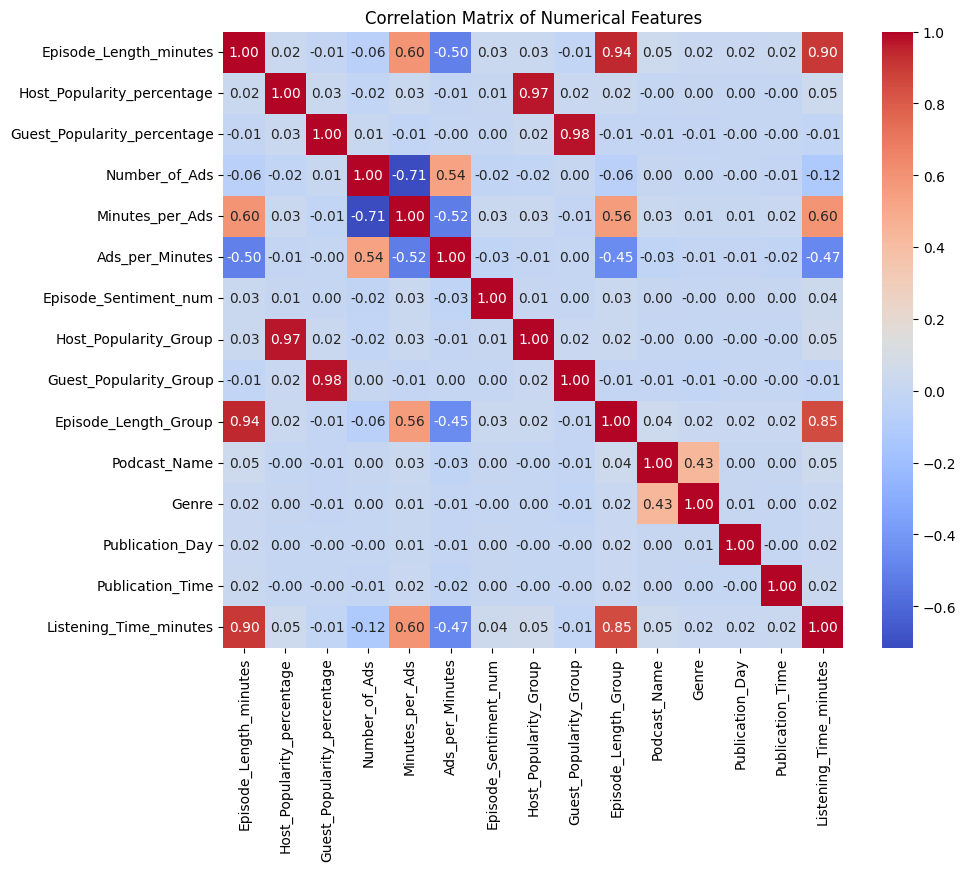

In [35]:
correlation_matrix = pd.concat([dataset_perfect.select_dtypes(include=['number']), target_column], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

As we see, columns that are linked to number_of_ads are having good correlation thanks to episode length, so i will keep it like this.

Will do the last part of analysis and move one to model training

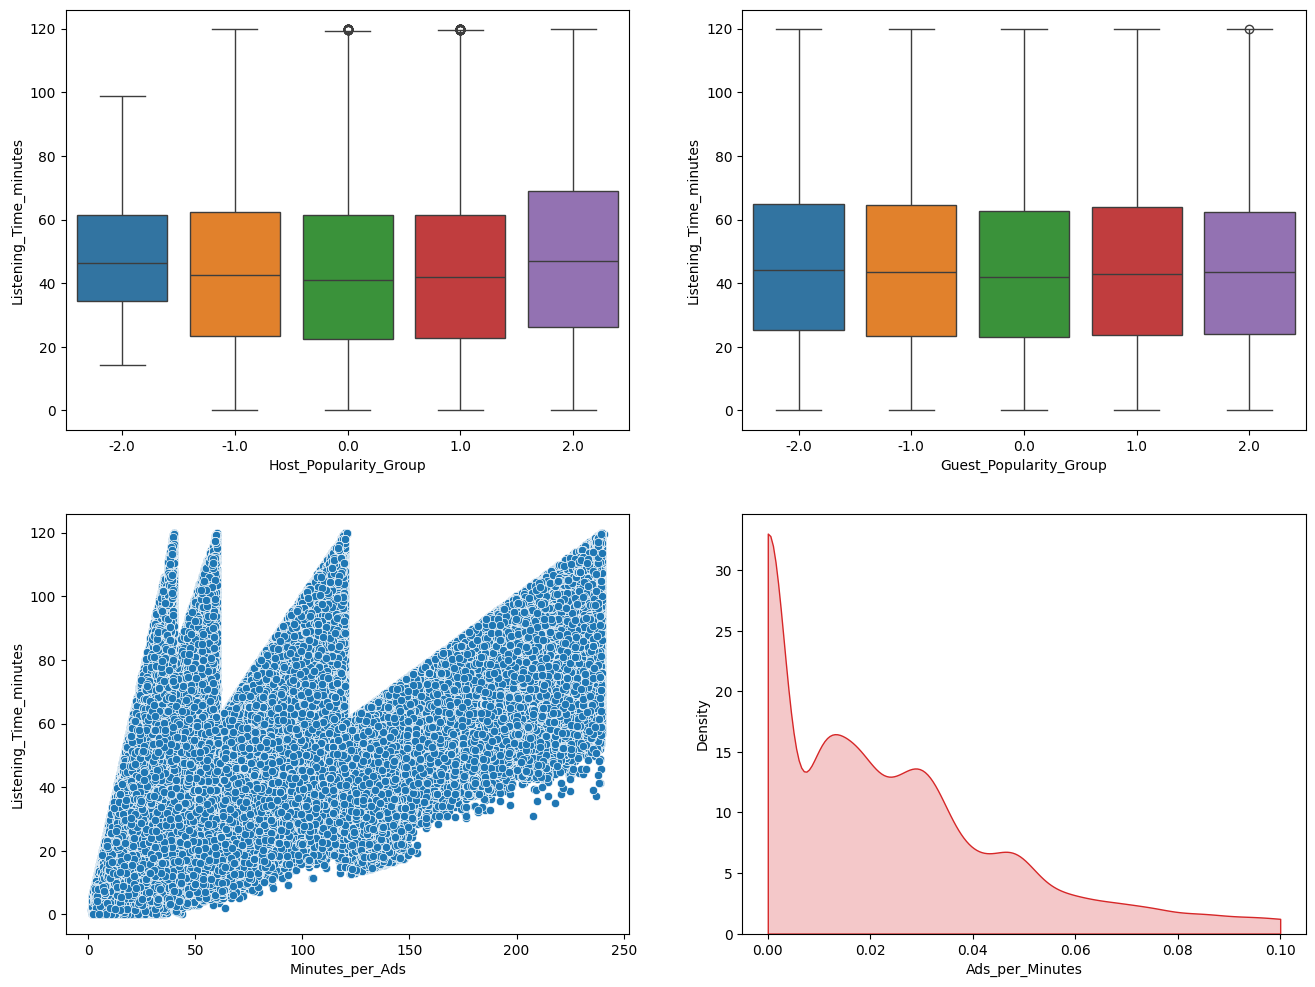

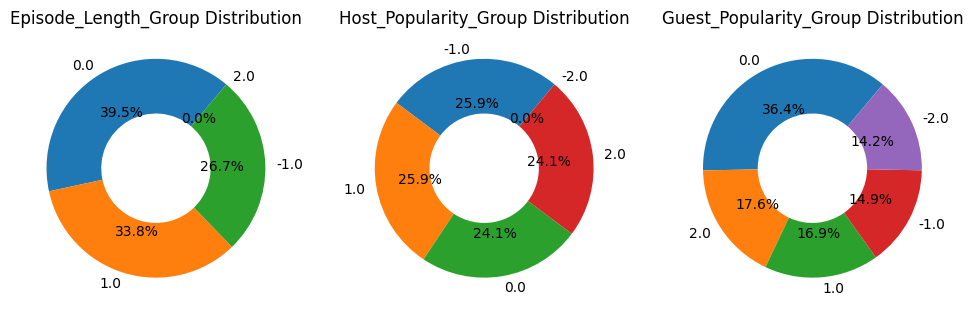

In [37]:
# host popularity group vs listening time minutes boxplot
# guest popularity group vs listening time minutes boxplot
# minutes per ads vs listening time 
# minutes per ads kde
# episode group donut
# host popularity group donut
# guest popularity group donut

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.boxplot(x=dataset_perfect['Host_Popularity_Group'], y=target_column, palette='tab10', ax=ax[0, 0])
sns.boxplot(x=dataset_perfect['Guest_Popularity_Group'], y=target_column, palette='tab10', ax=ax[0, 1])
sns.scatterplot(x=dataset_perfect['Minutes_per_Ads'], y=target_column, ax=ax[1, 0])
#ax[1, 0].hexbin(x=dataset_perfect['Minutes_per_Ads'], y=target_column, bins=30, cmap='Blues')
#ax[1, 0].set_xlabel('Minutes per ads')
#ax[1, 0].set_ylabel('Listening time minutes')
sns.kdeplot(x=dataset_perfect['Ads_per_Minutes'], color=color_dict['Number_of_Ads'], fill=True, clip=(0, 0.1), ax = ax[1, 1])

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
t = ['Episode_Length_Group', 'Host_Popularity_Group', 'Guest_Popularity_Group']
for i, col in enumerate(t):
    group_count = dataset_perfect[col].value_counts()
    ax[i].pie(group_count, labels=group_count.index, wedgeprops=dict(width=0.5), autopct='%1.1f%%', startangle=50)
    ax[i].set_title(f'{col} Distribution')


Key points:
+ Host popularity is equally destributed, while guest popularity has dominating neutrality
+ Host popularity group has a standout of 2.0, and at the same time unknown hosts are having better median score
+ Vast majority of podcasts showing of adds lesser then every 30 minutes

# Model training

In [40]:
train_data = dataset_perfect.select_dtypes(include=['number'])
#scaler = RobustScaler()
#train_data = scaler.fit_transform(train_data)
x_train, x_test, y_train, y_test = train_test_split(train_data, target_column, test_size=0.2, random_state=50)

params = {'objective': ['reg:squarederror'],
          'max_depth': [8, 10, 12],
          'alpha': [0],
          'lambda': [1],
          'learning_rate': [0.01, 0.05, 0.1, 0.2],
          'n_estimators': [250, 500, 750],
          'eval_metric': ['rmse']
         }

model = XGBRegressor()

searched = GridSearchCV(estimator = model,
                        param_grid = params,
                        scoring = 'neg_root_mean_squared_error',
                        refit = 'neg_root_mean_squared_error',
                        cv = 5,
                        verbose = 4,
                        error_score='raise')

# CPU times: total: 7h 6min 32s
# Wall time: 39min 43s
               
                        

In [41]:
#%%time

#searched.fit(x_train, y_train)
#print(searched.best_estimator_)

In [42]:
%%time

best_params = {'objective': 'reg:squarederror',
          'max_depth': 12,
          'alpha': 0,
          'lambda': 1,
          'learning_rate': 0.05,
          'n_estimators': 500,
          'eval_metric': 'rmse'
         }

best_model = XGBRegressor(**best_params)
best_model.fit(x_train, y_train, verbose=True)
y_pred = best_model.predict(x_test)
print(root_mean_squared_error(y_test, y_pred))

10.592906042889398
CPU times: total: 4min 12s
Wall time: 27.3 s


NOTE: this score will not match the kaggle result since we made a ton of data cleaning and the test dataset has unrealistic rows. In fact, there was 1 podcast with 150 millions years of length and he making the mean being 750 minutes literally solely, so this row can raise up the loss so high if your model will make a mistake. the kaggle result of this model is 13.25

# Analysing results

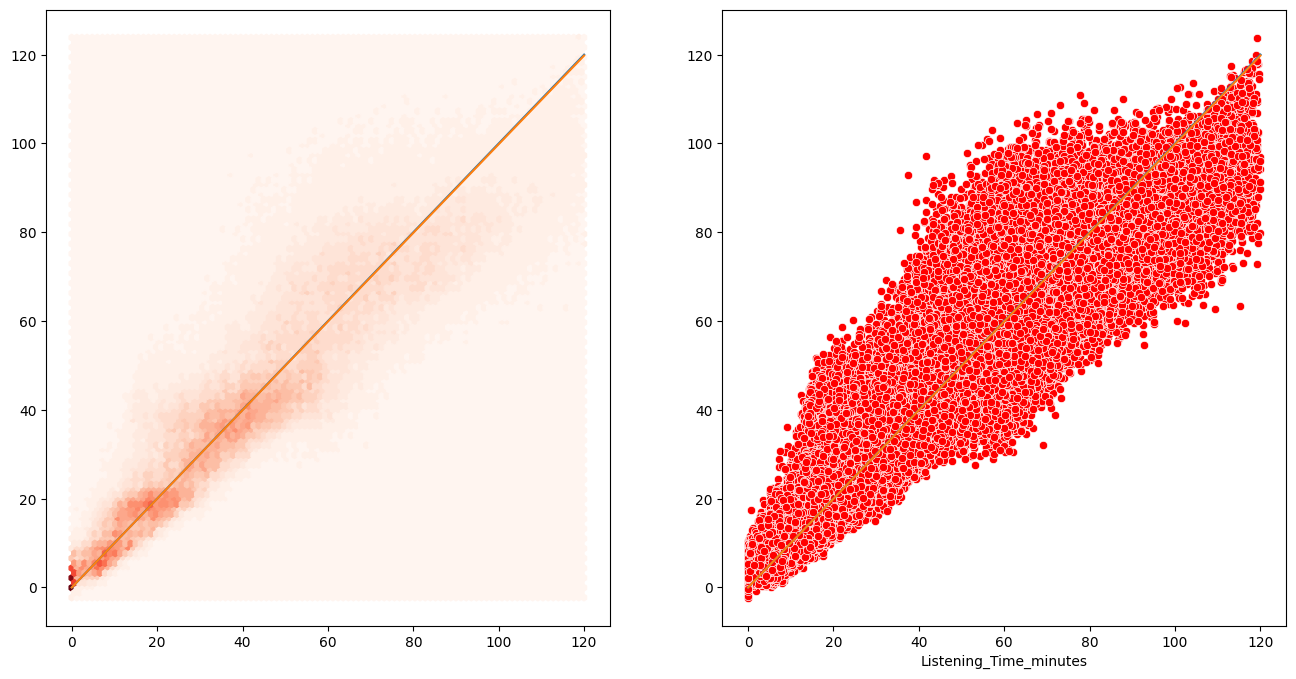

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hexbin(x=y_test, y=y_pred, bins=30, cmap='Reds')
ax[0].plot([0, 120], [0, 120])
sns.scatterplot(x=y_test, y=y_pred, color='red', ax=ax[1])
ax[1].plot([0, 120], [0, 120])

testing_line = LinearRegression()
testing_line.fit(pd.DataFrame({'a': y_pred, 'b': 1}), y_test)
coef = testing_line.coef_
ax[0].plot([0, 120], [0, 120*coef[0]])
ax[1].plot([0, 120], [0, 120*coef[0]])

Text(0.5, 0, 'Importance, %')

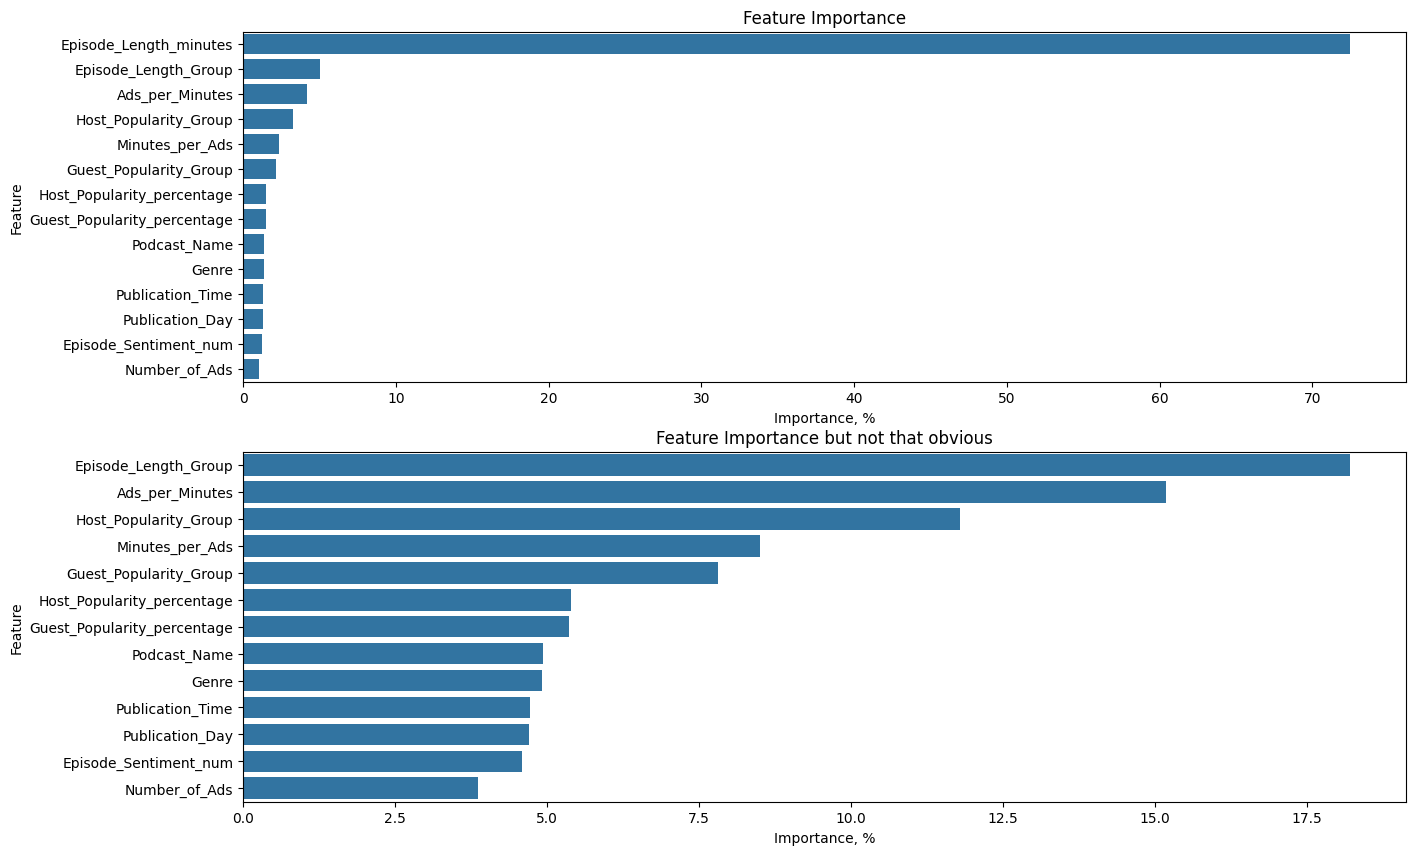

In [46]:
joblib.dump(best_model, './model.pkl')
model_job = joblib.load('./model.pkl')
feature_importance = pd.DataFrame({
    'Feature': model_job.feature_names_in_,
    'Importance': model_job.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.barplot(x=feature_importance['Importance']*100, y=feature_importance['Feature'], ax=ax[0])
ax[0].set_title('Feature Importance')
ax[0].set_xlabel('Importance, %')

feature_importance = feature_importance[feature_importance['Feature'] != 'Episode_Length_minutes']
feature_importance['Importance'] = feature_importance['Importance']/sum(feature_importance['Importance'])
sns.barplot(x=feature_importance['Importance']*100, y=feature_importance['Feature'], ax=ax[1])
ax[1].set_title('Feature Importance but not that obvious')
ax[1].set_xlabel('Importance, %')


Key points:
+ Episode length is dominating since high correlation, this gives motivation to use simplier algorithms like linear regression 
+ Even after testing L1-regularization other features didn't really disappear, all of them matter.
+ Seeing low episode sentiment importance is unexpactable, especially comparing to publication day / time, even though on graphics was seen clear medians correlation with target column. Episode_sentiment being target encoded showed 0% importance, so it was dropped.
+ categorical columns do not provide much information 

# Testing other algorithms

In [49]:
%%time

best_model = LinearRegression()
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print(root_mean_squared_error(y_test, y_pred))
coefficents = best_model.coef_
features = pd.DataFrame({
    'Feature': dataset_perfect.select_dtypes(include=['number']).columns,
    'Coef': coefficents
}).sort_values(by='Coef', ascending=False)
print(features)

11.143581698029875
                        Feature       Coef
5               Ads_per_Minutes  17.020688
0        Episode_Length_minutes   0.740098
7         Host_Popularity_Group   0.661753
6         Episode_Sentiment_num   0.487573
9          Episode_Length_Group   0.390402
13             Publication_Time   0.154088
10                 Podcast_Name   0.089475
4               Minutes_per_Ads   0.017347
2   Guest_Popularity_percentage   0.002644
1    Host_Popularity_percentage  -0.002902
12              Publication_Day  -0.078043
11                        Genre  -0.089859
8        Guest_Popularity_Group  -0.121821
3                 Number_of_Ads  -1.374404
CPU times: total: 1.09 s
Wall time: 288 ms


In [50]:

#best_model = svm.SVR(kernel='linear')
#best_model.fit(x_train, y_train)
#y_pred = best_model.predict(x_test)                          ---TOO LONG (> 10 min CPU)
#print(root_mean_squared_error(y_test, y_pred))


In [51]:

#best_model = svm.SVR(kernel='rbf')
#best_model.fit(x_train, y_train)                            ---TOO LONG
#y_pred = best_model.predict(x_test)
#print(root_mean_squared_error(y_test, y_pred))


In [52]:
%%time

lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 12,
    'reg_alpha' : 0,
    'reg_lambda' : 1
}
best_model = LGBMRegressor(**lgbm_params)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print(root_mean_squared_error(y_test, y_pred))

10.813596573929587
CPU times: total: 32.3 s
Wall time: 5.63 s


XGBoost > LightGBM in terms of speed
LightGBM < XGBoost in terms of result
Linear Regression does good for <1s compulations, so if dataset was extralarge it probably would have been best solution.